# Семинар по методам интеллектуального анализа данных
## Введение в сверточные нейронные сети и библиотеку Tensorflow 2.0

Содержание
- Задача классификации изображений
- Линейный классификатор
- Функция потерь, обучение линейного классификатора
- Сверточный слой нейросети
- Задачи, решаемые сверточными нейросетями

Отличный курс по нейросетям (видео лекций и материалы по курсу):

CS231n: Convolutional Neural Networks for Visual Recognition (Stanford)

http://cs231n.stanford.edu/

### Библиотека Tensorflow

<img align=left src="img/tf_logo.png">

https://www.tensorflow.org/

Другие библиотеки для обучения нейросетей (глубокого обучения - Deep learning):
- PyTorch https://pytorch.org/
- Apache MXNet https://mxnet.apache.org/
- Caffe2 https://caffe2.ai/

In [1]:
%matplotlib inline
import sys
import math
import tensorflow as tf
import pickle
import numpy as np
import sklearn
from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

print('Python version:', sys.version)
print('Tensorflow version:', tf.__version__)
print('Numpy version:', np.__version__)
print('Scikit-learn version:', sklearn.__version__)
print('Matplotlib version', matplotlib.__version__)

Python version: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
Tensorflow version: 2.0.0-alpha0
Numpy version: 1.16.2
Scikit-learn version: 0.20.3
Matplotlib version 3.0.3


In [2]:
# PATHS
PATH_CIFAR = Path('data') / 'cifar-10-batches-py'

### Задача классификации изображений

Пусть имеется набор изображений с известными метками классов (кошка, собака, машина и т.п.). Необходимо составить алгоритм, который будет определять метку класса для нового изображения. Наиболее известным набором размеченных изображений, на котором сравнивается качество разных алгоримов, является ImageNet, содержащий более 14 миллионов картинок, разделенных на 20000 классов.

Примеры изображений ImageNet:

![Imagenet_sample1](img/imagenet_sample1.jpg)
![Imagenet_sample1](img/imagenet_sample2.jpg)

Ежегодно проводится соревнование ImageNet Large Scale Visual Recognition Challenge (ILSVRC), где используется малая часть ImageNet (1.4 млн изображений, 1000 классов). В настоящее время нейросети показывают наилучшие результаты при решении этой задачи.

![Imagenet_winner_history](img/ILSVRC_winners.png)

- Deng et al, ImageNet: A Large-Scale Hierarchical Image Database, 2009.

Сети для классификации изображений ImageNet тренируются несколько дней. Чтобы уменьшить объем вычислений, мы будем использовать набор данных поменьше - **CIFAR**, который включает 10 классов, 50000 тренировочных и 10000 тестовых изображений.

CIFAR-10 можно загрузить по ссылке: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz и необходимо распаковать в папку data.

Изображения из набора данных CIFAR-10:

![CIRAR](img/cifar_classes.png)

In [3]:
def get_cifar10():
    CIFAR_DIM = (3, 32, 32)
    path_meta = PATH_CIFAR / 'batches.meta'
    paths_batches = [
        PATH_CIFAR / 'data_batch_1',
        PATH_CIFAR / 'data_batch_2',
        PATH_CIFAR / 'data_batch_3',
        PATH_CIFAR / 'data_batch_4',
        PATH_CIFAR / 'data_batch_5',    
    ]
    path_test = PATH_CIFAR / 'test_batch'
    
    # Train
    cifar10_train = {'data': [], 'labels': []}
    for path in paths_batches:
        with open(path, 'rb') as file:
            x = pickle.load(file, encoding='bytes')
            cifar10_train['data'].append(x[b'data'])
            cifar10_train['labels'].append(x[b'labels'])
    cifar10_train['data'] = np.concatenate(cifar10_train['data'])
    cifar10_train['data'] = cifar10_train['data'].reshape(-1, *CIFAR_DIM).transpose(0, 2, 3, 1)
    cifar10_train['labels'] = np.concatenate(cifar10_train['labels'])
    
    # Test
    cifar10_test = {}
    with open(path_test, 'rb') as file:
        x = pickle.load(file, encoding='bytes')
        cifar10_test['data'] = x[b'data'].reshape(-1, *CIFAR_DIM).transpose(0, 2, 3, 1)
        cifar10_test['labels'] = np.array(x[b'labels'], dtype=np.int32)
    
    # Class names
    with open(path_meta, 'rb') as file:
        class_names = [bytes_name.decode() for bytes_name 
                       in pickle.load(file, encoding='bytes')[b'label_names']]
    
    return cifar10_train, cifar10_test, class_names

In [4]:
# Загрузим датасет CIFAR10
cifar10_train, cifar10_test, class_names = get_cifar10()

cifar10_train_size = cifar10_train['data'].shape[0]
cifar10_test_size = cifar10_test['data'].shape[0]

# Нам также понадобяться изображения в виде вектора пикселей
# длиной 3072 = 32x32x3
cifar10_train_vectors = cifar10_train['data'].reshape(cifar10_train_size, -1)
cifar10_test_vectors = cifar10_test['data'].reshape(cifar10_test_size, -1)

print('Имена классов:', class_names)
print('Размер тренировочных данных:', cifar10_train_size)
assert cifar10_train_size == cifar10_train['labels'].size
print('Размер тестовых данных:', cifar10_test_size)
assert cifar10_test_size == cifar10_test['labels'].size
print('Размер изображения: {} (32x32x3)'.format(cifar10_train['data'].shape[1]))
print('Количество пикселей на изображении: {}'.format(np.product(cifar10_train['data'].shape[1:])))

Имена классов: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Размер тренировочных данных: 50000
Размер тестовых данных: 10000
Размер изображения: 32 (32x32x3)
Количество пикселей на изображении: 3072


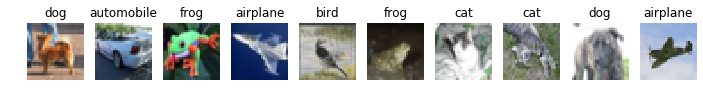

In [5]:
# Построим 10 случайных изображений CIFAR
def plot_cifar_imgs(imgs, labels, interpolation=None):
    plt.figure(figsize=(len(imgs) + 2, 3))
    for img_num, (img, lbl) in enumerate(zip(imgs, labels), 1):
        plt.subplot(1, len(imgs), img_num)
        plt.imshow(img, interpolation=interpolation)
        plt.title(class_names[lbl])
        plt.axis('off')

show_idxs = np.random.randint(0, cifar10_train_size, size=10)
images = [cifar10_train['data'][idx] for idx in show_idxs]
labels = [cifar10_train['labels'][idx] for idx in show_idxs]
plot_cifar_imgs(images, labels)

In [6]:
# Посмотрим на распредление классов
print(np.unique(cifar10_train['labels'], return_counts=True)[1])
print(np.unique(cifar10_test['labels'], return_counts=True)[1])

[5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


Видно, что изображения CIFAR10 распределены по классам равномерно.

### Обучение однослойной нейросети
В основе нейросети лежит линейная функция (простейший классификатор):

$$y = Wx + b,$$

где $x$ - входной вектор $\mathbb{R}^N$, $y$ - выходной вектор  $\mathbb{R}^M$, $W$ - матрица весов $\mathbb{R}^{M \times N}$, $b$ - вектор смещений $\mathbb{R}^M$.

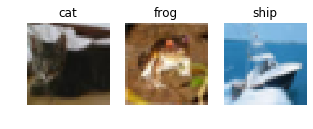

In [7]:
# Возмем 3 изображения разных классов
labels = [3, 6, 8]
images = np.stack([cifar10_train['data'][np.where(cifar10_train['labels'] == lbl)[0][0]] for lbl in labels])
plot_cifar_imgs(images, labels)

In [8]:
# Представим изображения в виде векторов длинной 3072 = 32x32x3
images = images.reshape(3, -1)

In [9]:
# Создадим случайную матрицу весов и вектор смещений
n = images[0].shape[0]
m = 10  # 10 классов
weights = tf.random.normal((m, n)) / 10
bias = tf.random.normal((m, ))

In [10]:
# Применим линейную функцию к изображениям
# images - numpy массив, weights - tensorflow массив, но их можно перемножать
y = images @ tf.transpose(weights) + bias  # @ - умножение матриц (== tf.matmul)
print(y)  # получается tensorflow массив

tf.Tensor(
[[ 278.96497  -373.84625   530.5867    104.04567   557.5654     47.605877
  -624.4115    691.2342   -237.60196   693.433   ]
 [-617.0538    694.3246    946.81396   786.84717  -380.98947  -126.20673
  -462.07822   989.2734    347.8658    895.97003 ]
 [-693.7989   -663.58636  1069.4034    433.301    -129.90227   256.27893
  -550.062     988.89465   476.08896  1067.7925  ]], shape=(3, 10), dtype=float32)


Каждое число (или score) можно интерпретировать, как принадлежность каждого изображения к одному из 10 классов. Тот индекс, где score наибольший и есть предсказанный класс.

In [11]:
predictions = tf.argmax(y, axis=1)
for true_label, prediction in zip(labels, predictions):
    print('Предсказание для изображения {}: {}'
          ''.format(class_names[true_label], class_names[prediction]))

Предсказание для изображения cat: truck
Предсказание для изображения frog: horse
Предсказание для изображения ship: bird


In [12]:
# Введем метрику для оценки качества предсказаний
def estimate_accuracy(input_weights, input_bias, input_data, input_labels):
    y = input_data @ tf.transpose(input_weights) + bias
    return accuracy_score(input_labels, tf.argmax(y, axis=1))

In [13]:
# Оценим качество предсказания для тестовой выборки для наших текущих, случаных весов
cifar10_test_predictions_random_weights = estimate_accuracy(
    weights, bias, cifar10_train_vectors, cifar10_train['labels']
)
print('Точность предсказания: {:.2f}%'.format(cifar10_test_predictions_random_weights * 100))

Точность предсказания: 10.08%


Точность находится в пределах 10%, потому что у нас 10 классов, а предсказание - случайное. Чтобы найти веса, которые позволят лучше разделять классы необходимо ввести функцию потерь, которая будет штрафовать классификатор за неверные предсказания классов. Один из вариатов таких функций является Hinge loss, которая применятся в методе опорных векторов (SVM):

$$L = \max(0, 1 + \max\limits_{i\neq t}(y_i - y_t)),$$

$y_t$ - значения предсказания для истинного класса. Если максимальное значение среди предсказаний соотсветствует истинному классу, значение функции потерь равно0, если другому классу, то $L > 0$.

In [14]:
# В Tensorflow 2.0 функции потерь находяться в модуле tf.losses
hinge_loss = tf.losses.CategoricalHinge()

# Однако на вход функции необходимо подавать не индексы классов, 
# а вектор 0 и 1 длиной 10 (например, 3 класс преобразуется в [0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
# Это называется one-hot-encoding
one_hot_labels = tf.one_hot(labels, depth=10)
print('Закодированные метки классов:\n{}\n'.format(one_hot_labels))
loss = hinge_loss(one_hot_labels, y)
print('Значение функции потерь (усреднение по трем предсказаниям): {:.2f}'.format(loss.numpy().item()))

Закодированные метки классов:
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

Значение функции потерь (усреднение по трем предсказаниям): 879.02


Hinge loss - выпуклая, но недифференцируемая функция, однако при минимизации этим пренебрегают. Теперь мы может использовать простейший градиентый спуск для того чтобы найти оптимальные весовые коэффициенты.

In [15]:
# Tensorflow обладает модулем автоматического дифференцирования
# Однако, чтобы получить доступ к градиентам необходимо указать,
# какие переменные должны отслеживаться.
# Это необходимо, так как мы используем динамические вычисления
# (раньше Tensorflow составлял граф всех необходимых вычислений,
# который испольнялся в специальной сессии)
with tf.GradientTape() as g:
    g.watch(weights)
    y = images @ tf.transpose(weights) + bias
    loss = hinge_loss(one_hot_labels, y)

dL_dW = g.gradient(loss, weights)
print(dL_dW)

tf.Tensor(
[[  0.         0.         0.       ...   0.         0.         0.      ]
 [  0.         0.         0.       ...   0.         0.         0.      ]
 [ 44.666668  62.        74.333336 ...  10.666667  31.333334  46.      ]
 ...
 [ 19.666668  20.666668  21.       ...  41.        30.666668  24.      ]
 [-44.666668 -62.       -74.333336 ... -10.666667 -31.333334 -46.      ]
 [ 41.666668  41.666668  38.666668 ...  48.        38.666668  28.666668]], shape=(10, 3072), dtype=float32)


In [16]:
# У нас есть все инструменты для написания простого алгоритма градиентного спуска
# Параметры обучения
batch_size = 128
learning_rate = 0.001
n_epochs = 10

# Эпохами называют проход по всем изображениям набора данных
for epoch in range(n_epochs):    
    print('Эпоха {}/{}'.format(epoch + 1, n_epochs))
    
    # Разобъем имеющиеся данные на батчи по 128 изображений
    # Таким образом мы получаем стохастический градиентный спуск
    # и при этом алгоритм не будет работь слишком медленно
    for batch_num in range(math.ceil(cifar10_train_size / batch_size)):
        sl = slice(batch_num * batch_size,
                   min((batch_num + 1) * batch_size, cifar10_train_size))
        batch_train = cifar10_train_vectors[sl]
        batch_labels = cifar10_train['labels'][sl]
        one_hot_labels = tf.one_hot(batch_labels, depth=10)
        
        # Фиксируем градиенты весов и смещений
        with tf.GradientTape() as g:
            g.watch([weights, bias])
            
            # Однослойный линейный классификатор
            y = batch_train @ tf.transpose(weights) + bias
            loss = hinge_loss(one_hot_labels, y)
        
        # Делаем шаг в направлении убывания градиента
        dL_dW, dL_db = g.gradient(loss, [weights, bias])
        weights -= learning_rate * dL_dW
        bias -= learning_rate * dL_db
    
    # Уменьшаем скорость обучения с каждой пройденой эпохой
    # На первых эпохах происходит грубая подгонка весов,
    # затем они уточняются
    learning_rate /= 2

    # Оченим качество предсказаний на всем тренировочном и тестовом датасете
    accuracy_train = estimate_accuracy(weights, bias, cifar10_train_vectors, cifar10_train['labels'])
    accuracy_test = estimate_accuracy(weights, bias, cifar10_test_vectors, cifar10_test['labels'])

    print('Точность на тренировочных данных: {:.2f}%'.format(accuracy_train * 100))
    print('Точность на тeстовых данных: {:.2f}%'.format(accuracy_test * 100))

Эпоха 1/10
Точность на тренировочных данных: 21.53%
Точность на тeстовых данных: 22.16%
Эпоха 2/10
Точность на тренировочных данных: 21.49%
Точность на тeстовых данных: 21.40%
Эпоха 3/10
Точность на тренировочных данных: 22.73%
Точность на тeстовых данных: 22.45%
Эпоха 4/10
Точность на тренировочных данных: 31.02%
Точность на тeстовых данных: 30.19%
Эпоха 5/10
Точность на тренировочных данных: 33.98%
Точность на тeстовых данных: 32.70%
Эпоха 6/10
Точность на тренировочных данных: 37.67%
Точность на тeстовых данных: 35.16%
Эпоха 7/10
Точность на тренировочных данных: 38.00%
Точность на тeстовых данных: 35.27%
Эпоха 8/10
Точность на тренировочных данных: 37.98%
Точность на тeстовых данных: 35.22%
Эпоха 9/10
Точность на тренировочных данных: 38.04%
Точность на тeстовых данных: 35.19%
Эпоха 10/10
Точность на тренировочных данных: 37.98%
Точность на тeстовых данных: 35.13%


Конечно в tensorflow есть более простые способы для обучения классификатора.

In [17]:
# Например, tf.optimizers содержат готовые алгоритмы оптимизации
# (реализации одного "шага" изменения весов)
# Однако из интерфейс привязан к представлению статичных графов tensorflow
# Веса и смещения должны быть обернуты в специальный класс tf.Variable
# Это те тензоры, значения которых не должны меняться по мере обучения
weights = tf.Variable(tf.random.normal((m, n)))
bias = tf.Variable(tf.random.normal((m, )))

# Оптимизатор Stochastic gradient descent
sgd = tf.optimizers.SGD(learning_rate=0.001)

# Оптимизируемая функция
def foo():
    y = batch_train @ tf.transpose(weights) + bias
    return hinge_loss(one_hot_labels, y)

# Один шаг изменения весов
print('Смещение до шага минимизации:', bias.numpy())
sgd.minimize(foo, [weights, bias]);
print('Смещение после шага минимизации:', bias.numpy())

Смещение до шага минимизации: [ 1.3420424  -1.8466502  -1.308539    0.38557678  0.08406472  0.37971517
 -0.03453567 -0.5170687  -0.27184507 -0.89503306]
Смещение после шага минимизации: [ 1.3421049  -1.8473502  -1.3084891   0.38570178  0.08402722  0.37980267
 -0.03442317 -0.5169562  -0.27173257 -0.8949581 ]


# Место для рассказа про статический граф

Tensorflow также обладает более высокоуровненым интерфейсом:
![tf_api](img/tensorflow_api.png)

Основные компоненты библиотеки и иструменты для распределенных вычислений написаны на C++ и CUDA. Наиболее полноценный и задокументированный API написан Python, но есть интерфейсы и для других языков. 

tf.losses, tf.optimizers, tf.GradientTape являются элементами низкого уровня, полезными, когда необходимо реализовать функционал, который отсутствует в API верхнего уровня. Создатели библиотеки рекомендуют использовать высокоуровнений API - tf.estimator и tf.keras (начиная с Tensorflow 2.0 утверждается, что tf.keras почти такой же быстрый).

**tf.estimator** содержит готовые модели, включающие обучение, оценку, предсказание и экспорт моделей. https://www.tensorflow.org/guide/estimators

**tf.keras** позволяет легко создавать собственные модели. https://www.tensorflow.org/guide/keras

In [18]:
# Построим с помощью keras такой же однослойный классификатор, как и ранее

# Параметры
learning_rate = 0.01

def lr_schedule(epoch):
    return learning_rate / (2 ** epoch)

batch_size = 128
n_epochs = 10

# Создадим линейный слой 3072 -> 10
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=(3072, )),
])

# Зададим параметры обучения с помощью model.compile()
model.compile(
    optimizer=tf.optimizers.SGD(learning_rate=learning_rate),
    loss=tf.losses.CategoricalHinge(),
    metrics=['categorical_accuracy']
)

# Не нужно разбивать набор на батчи и создавать цикл по эпохам,
# keras все сделает сам, задаем только параметры

model.fit(
    x=cifar10_train_vectors / 255.0,
    y=tf.one_hot(cifar10_train['labels'], depth=10),
    batch_size=batch_size,
    epochs=n_epochs,
    # Тестовые данные в качестве валидации
    validation_data=(cifar10_test_vectors / 255.0, tf.one_hot(cifar10_test['labels'], depth=10)),
    # callbacks - это набор функций, которые будут вызываться каждую эпоху
    callbacks=[tf.keras.callbacks.LearningRateScheduler(schedule=lr_schedule)],
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s 63us/sample - loss: 1.9329 - categorical_accuracy: 0.2105 - val_loss: 1.8935 - val_categorical_accuracy: 0.2259
Epoch 2/10
50000/50000 [==============================] - 3s 59us/sample - loss: 1.2452 - categorical_accuracy: 0.3105 - val_loss: 1.2380 - val_categorical_accuracy: 0.3042
Epoch 3/10
50000/50000 [==============================] - 3s 60us/sample - loss: 1.1278 - categorical_accuracy: 0.3472 - val_loss: 1.1385 - val_categorical_accuracy: 0.3198
Epoch 4/10
50000/50000 [==============================] - 3s 59us/sample - loss: 1.1001 - categorical_accuracy: 0.3566 - val_loss: 1.1093 - val_categorical_accuracy: 0.3342
Epoch 5/10
50000/50000 [==============================] - 3s 56us/sample - loss: 1.0912 - categorical_accuracy: 0.3591 - val_loss: 1.0976 - val_categorical_accuracy: 0.3396
Epoch 6/10
50000/50000 [==============================] - 3s 57us/sample - loss: 1.08

In [19]:
# Можно извлечь веса модели и оценик точность самостоятельно
weights, bias = model.get_weights()

accuracy_train = estimate_accuracy(weights.T, bias, cifar10_train_vectors, cifar10_train['labels'])
accuracy_test = estimate_accuracy(weights.T, bias, cifar10_test_vectors, cifar10_test['labels'])

print('Точность на тренировочных данных: {:.2f}%'.format(accuracy_train * 100))
print('Точность на тeстовых данных: {:.2f}%'.format(accuracy_test * 100))

Точность на тренировочных данных: 35.58%
Точность на тeстовых данных: 34.39%


In [20]:
# !Использовать tf.metrics
...
...
...

Чаще в качестве функции потерь для задачи определения меток взаимоисключающих классов используется перекрестная энтропия (**cross-entropy loss**). Метки классов - это вектор нулей и единиц (например, кошка в CIFAR-10 - [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]), который можно интерпретировать как вероятность принадлежности к классу, поэтому удобно, когда выходные значения нейросети тоже представляют собой вероятности.

Функция **softmax** позволяет отнормировать предсказания линейного слоя ($y$) и получить подобие вероятностного распределения:

$$z = \sigma(y)_i = \frac{e^{y_i}}{\sum\limits_{k=1}^K e^{y_k}}$$

**Cross-entropy loss** - это функция потерь, которая исользует истинное и предсказанное распределение классов:

$$L = \frac{1}{N} \sum\limits_{n=1}^N H(p_n, q_n)
    = -\frac{1}{N} \sum\limits_{n=1}^N [z_n \log \hat{z}_n + (1 - z_n)\log(1 - \hat{z}_n)],$$
    
где $p$ - истинное распределение классов, $q$ - распределение, предсказанное моделью, $N$ - размер выборки. Чем больше предсказанная вероятность для истинного класса, тем меньше значение функции потерь. Однако, как видно из формулы, если модель предскажет 1 там, где должен быть 0, функция потерь $L = \infty$. Это приводит к тому, что модели, обученные с помощью перекрестной энтропии, никогда не уверенны до конца в своих предсказаниях.

In [21]:
# Однослойный классификатор с cross-entropy loss
# Дополнительно указываем, что к выходам линейного слоя должна быть применена
# функция softmax
learning_rate = 5.

# Чтобы классификатор бысрее обучался, а также для того чтобы получить
# красивые картинки весов, вычтем среднее и разделим на дисперсию
mean, var = cifar10_train_vectors.mean(), cifar10_train_vectors.var()

model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=(3072, ), activation='softmax'), 
])

model.compile(
    optimizer=tf.optimizers.SGD(learning_rate=learning_rate),
    # изменяем функцию потерь
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=['categorical_accuracy']
)

model.fit(
    x=(cifar10_train_vectors - mean) / var,
    # Как и для Hinge loss, здесь ожидается, что метки классов закодированы
    y=tf.one_hot(cifar10_train['labels'], depth=10),
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=((cifar10_test_vectors - mean) / var, tf.one_hot(cifar10_test['labels'], depth=10)),
    callbacks=[tf.keras.callbacks.LearningRateScheduler(schedule=lr_schedule)],
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s 57us/sample - loss: 1.9110 - categorical_accuracy: 0.3339 - val_loss: 1.8277 - val_categorical_accuracy: 0.3698
Epoch 2/10
50000/50000 [==============================] - 3s 53us/sample - loss: 1.8039 - categorical_accuracy: 0.3812 - val_loss: 1.7888 - val_categorical_accuracy: 0.3847
Epoch 3/10
50000/50000 [==============================] - 3s 54us/sample - loss: 1.7831 - categorical_accuracy: 0.3913 - val_loss: 1.7832 - val_categorical_accuracy: 0.3861
Epoch 4/10
50000/50000 [==============================] - 3s 54us/sample - loss: 1.7753 - categorical_accuracy: 0.3941 - val_loss: 1.7749 - val_categorical_accuracy: 0.3925
Epoch 5/10
50000/50000 [==============================] - 3s 55us/sample - loss: 1.7713 - categorical_accuracy: 0.3957 - val_loss: 1.7730 - val_categorical_accuracy: 0.3921
Epoch 6/10
50000/50000 [==============================] - 3s 54us/sample - loss: 1.76

In [22]:
def renormalize(x):
    shape = x.shape
    x = x.reshape(shape[0], -1)
    x = ((x - x.min(axis=1, keepdims=True))
         / x.ptp(axis=1, keepdims=True) * 255.0).astype(np.uint8)
    return x.reshape(shape)

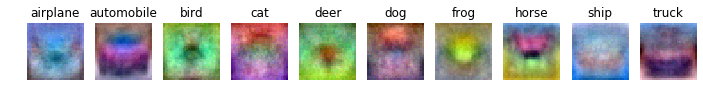

In [23]:
# Посмотрим на изображение весов модели
weights = model.get_weights()[0]  # 3072 x 10
weights = weights.T  # 10 x 3072
# Отнормируем веса в диапазон [0..255]
weights = renormalize(weights)
# 3072 = 32х32х3
weights = weights.reshape(10, 32, 32, 3)
plot_cifar_imgs(weights, np.arange(10))

Видно, что классификатор пытается уловить средние цвета и форму изображений разных классов.

## Обучения двухслойной сети
Линейный классификатор можно интерпретировать как поверхность, разделяющую разные классы в многомерном прострастве всех возможноых пикселей.

![linear_separation](img/linear_separation.png)

Чтобы получить поверхности более сложной формы используют несколько линейный слоев, причем к выходу каждого слоя применятся нелинейная функция - активация. Если не применять активацию, то сколько бы линейных слоев мы не сделали, все они могут быть выражены одним линейным слоем. Понятие искуственной нейронной сети применяют именно к набору линейных слоев с активациями, по аналогии с нейронами у животных.

Разные функции активации:

![activations](img/activations.png)

In [24]:
# Двухслойная нейросеть
learning_rate = 0.1
hidden_layer = 256  # размерность выходов первого слоя сети (их называют скрытыми)

model = tf.keras.Sequential([
    # Добавляем дополнительный слой [3072 -> 256] с активацией ReLU (Rectifier Linear Unit)
    tf.keras.layers.Dense(256, input_shape=(3072, ), activation='relu'), 
    # [256 -> 10]
    tf.keras.layers.Dense(10, activation='softmax'),     
])

model.compile(
    optimizer=tf.optimizers.SGD(learning_rate=learning_rate),
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=['categorical_accuracy']
)

model.fit(
    x=(cifar10_train_vectors / 255.),
    y=tf.one_hot(cifar10_train['labels'], depth=10),
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=(cifar10_test_vectors / 255., tf.one_hot(cifar10_test['labels'], depth=10)),
    callbacks=[tf.keras.callbacks.LearningRateScheduler(schedule=lr_schedule)],
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s 58us/sample - loss: 2.0365 - categorical_accuracy: 0.2589 - val_loss: 1.8587 - val_categorical_accuracy: 0.3302
Epoch 2/10
50000/50000 [==============================] - 3s 54us/sample - loss: 1.7602 - categorical_accuracy: 0.3716 - val_loss: 1.7270 - val_categorical_accuracy: 0.3835
Epoch 3/10
50000/50000 [==============================] - 3s 53us/sample - loss: 1.6788 - categorical_accuracy: 0.4088 - val_loss: 1.6867 - val_categorical_accuracy: 0.3954
Epoch 4/10
50000/50000 [==============================] - 3s 57us/sample - loss: 1.6419 - categorical_accuracy: 0.4245 - val_loss: 1.6407 - val_categorical_accuracy: 0.4200
Epoch 5/10
50000/50000 [==============================] - 3s 61us/sample - loss: 1.6236 - categorical_accuracy: 0.4332 - val_loss: 1.6243 - val_categorical_accuracy: 0.4254
Epoch 6/10
50000/50000 [==============================] - 3s 57us/sample - loss: 1.61

По мере роста глубины сети и размерности скрытых слоев, точность будет немного возрастать и выйдет на плато. Такие сети, где все нейроны соседних слоев связаны между собой, называют полносвязными (**Fully-connected nets**).

![fully_connected](img/fully_connected.png)

Качество предсказаний такой модели мало отличается от деревьев решений (если не меньше), поскольку все пиксели изображений рассматриваются по отдельности. Если мы перемешаем все пиксели на всех изображениях одинаковым образом, качество предсказаний не измениться.

Чтобы включить в сеть информацию о простраственной связности пикселей, используют сверточные нейросети.

## Сверточные нейросети

В основе сверточных сетей лежит идея совместного использования весовых коэффициентов. Изображение сворачивают с фильтром заданного размера, веса которого одинаковы для всех дискретных положений свертки. Вся операция характеризуется шириной, высотой и глубиной фильтров (если мы имеем дело с двумерными изображениями), а также смещением положения фильтра на каждом шаге свертки и поведением на границах изображения.

![convolution](img/convolution.gif)

В данном случае мы имеем фильтр с размерностью 3x3x1, применяемому к изображению 5х5х1 со смещением (**strides**), равным двум и добавлением пикселей-заполнителей по краям (**padding**). Кроме того, варьируется количество самих фильтров. В зависимости от значений всех этих параметров, на выходе **сверточного слоя** сети получаются матрицы признаков (**feature maps**) разной размерности. Например, изображением имеет размерность 32х32х3; тогда после применения 5 фильтров с размерами 7х7 и шагом 5, выходная матрица признаков будет иметь размерость 6х6х5:

$$Размер~выхода = \frac{N - F}{stride} + 1 = \frac{32 - 7}{5} + 1 = 6$$

Здесь нам не нужно дополнительно заполнение по краям, так как все фильтры умещаются в изображение с заданным шагом. По мере мере роста числа последовательных слоев, на каждый нейрон будет приходится все больше информации исходного изображения. 

![receptive_field](img/receptive_field.png)

Таким образом, веса нейрона кодируют базовое изображения и мы получаем сжатое представление об информации на изображении. Начальные сверточные слои захватывают информацию о текстурах на избражении (брусчатка/шерсть/кирпичи), а финальные слои - информацию о содержании изображения (улица/кошка/дом).

Часто в сверточных сетях размерности по ширине и высоте сохраняются и меняется только число фильтров (либо и оно тоже остается постоянным, а слой только увеличивает глубину сети).

Несмотря на то, что сети называют сверточными, в практических приложениях используется операция кросс-корреляции (фильтры в этом случае не перевернуты).

In [25]:
# Теперь на вход сети будут подоваться не векторы длиной 3072, а изображения
# Вычтем среднее и отнормируем их
mean, std = cifar10_train['data'].mean(), cifar10_train['data'].var()
cifar10_train_norm_img = (cifar10_train['data'] - mean) / std
cifar10_test_norm_img = (cifar10_test['data'] - mean) / std

In [26]:
# Tensorflow содержит модуль tf.nn, в котором реализованы сверточные слои tf.nn.conv2d
# tf.keras также включает необходимые классы

learning_rate = 0.01

model = tf.keras.Sequential([
    # Задаем сверточный слой 7x7, на выходе получаем 26x26x32 нейрона
    tf.keras.layers.Conv2D(filters=32, kernel_size=(7, 7), strides=(1, 1), activation='relu',
                           input_shape=(32, 32, 3)),
    # Задаем pooling слой. По умолчанию 2x2, следовательно на выходе 13x13x32
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'), 
    # Финальный слой обычно делают полносвязным, но это не обязательно
    # (необходимо, чтобы количество выходных нейронов было равно числу классов)
    tf.keras.layers.Dense(10, activation='softmax'),     
])

model.compile(
    # Воспользуемся более продвинутым оптимизатором
    # Adam (adaptive moment estimation) - это разновидность SGD,
    # включающая момент (инерция изменения градиента)
    # и подстройку значения градиента под отдельные параметры
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=['categorical_accuracy']
)

model.fit(
    x=cifar10_train_norm_img,
    y=tf.one_hot(cifar10_train['labels'], depth=10),
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=(cifar10_test_norm_img, tf.one_hot(cifar10_test['labels'], depth=10)),
    callbacks=[tf.keras.callbacks.LearningRateScheduler(schedule=lr_schedule)],
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 133us/sample - loss: 1.4945 - categorical_accuracy: 0.4633 - val_loss: 1.2970 - val_categorical_accuracy: 0.5419
Epoch 2/10
50000/50000 [==============================] - 5s 98us/sample - loss: 1.1128 - categorical_accuracy: 0.6061 - val_loss: 1.1307 - val_categorical_accuracy: 0.6032
Epoch 3/10
50000/50000 [==============================] - 5s 97us/sample - loss: 0.9056 - categorical_accuracy: 0.6807 - val_loss: 1.0630 - val_categorical_accuracy: 0.6321
Epoch 4/10
50000/50000 [==============================] - 5s 96us/sample - loss: 0.7753 - categorical_accuracy: 0.7304 - val_loss: 1.0454 - val_categorical_accuracy: 0.6438
Epoch 5/10
50000/50000 [==============================] - 5s 97us/sample - loss: 0.7014 - categorical_accuracy: 0.7587 - val_loss: 1.0361 - val_categorical_accuracy: 0.6507
Epoch 6/10
50000/50000 [==============================] - 5s 96us/sample - loss: 0.6

Размерность весов первого слоя: (7, 7, 3, 32)


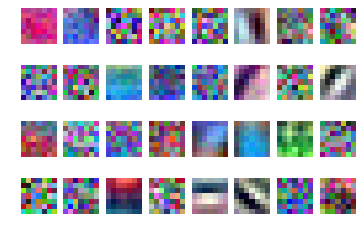

In [27]:
# Постоим веса
weights = model.get_weights()[0]
print('Размерность весов первого слоя:', weights.shape)

weights = weights.transpose(3, 0, 1, 2)
weights = renormalize(weights)

fig, axes = plt.subplots(4, 8, figsize=(6, 4))
axes = axes.ravel()
for ax, w in zip(axes, weights):
    ax.imshow(w.astype('uint8'))
    ax.axis('off')


Сеть даже с одним сверточным слоем достаточно быстро набирает хорошую точность на тренировочный выборке, по сравнению с полносвязной сетью. Однако разница в точности предсказаний на тренеровочных и тестовых данных возросла. Поэтому необходима дополнительная регуляризация.

## Задачи, решаемые сверточными нейросетями
- Классификация изображений
- Сегментация (instance и semantic segmentation)
- Подсчет объектов